In [140]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder

# 可視化ツールのimport
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import tensorflow as tf
from keras import models, layers, callbacks, initializers, regularizers
from keras.layers import ELU, Dense, Dropout
from keras.utils import plot_model

import optuna

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))
#色コード
class CLR:
    map_1 = 'GnBu'
    blue_thin = '#88CAC9'
    blue_dark = '#38A6A5'
    pink_thin = '#eb8792'
    pink_dark = '#ec616e'
    orange = '#f8b287'
    orange_dark = '#ee572a'

c:\Users\Intern\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [141]:
df_train = pd.read_csv('./kaggle/input/titanic/train.csv')
df_test = pd.read_csv('./kaggle/input/titanic/test.csv')
df_example = pd.read_csv('./kaggle/input/titanic/gender_submission.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<div style="padding:20px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#38A6A5;overflow:hidden;font-weight:500">データの前処理</div>

In [142]:
def preprocess(df:pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    droped_columns = ['PassengerId','Name','Ticket',"Cabin"]
    df = df.drop(columns=droped_columns)
    df = df.fillna(df.mode().iloc[0])
    df = pd.get_dummies(df)
    return df

df_preprocessed = preprocess(df_train)
df_preprocessed.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,False,True,False,False,True


In [143]:
# 欠損値がないか確認
df_preprocessed.isnull().sum(axis=0)#データの欠測値を一覧表示

Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [144]:
from sklearn.preprocessing import StandardScaler

target_column = df_preprocessed['Survived']
df_preprocessed.drop(columns='Survived', inplace=True)

scaler=StandardScaler()
df_scaled =pd.DataFrame(scaler.fit_transform(df_preprocessed),columns=df_preprocessed.columns)
# price列を元のDataFrameに結合
df_scaled['Survived'] = target_column
df_scaled 

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Survived
0,0.827377,-0.497793,0.432793,-0.473674,-0.502445,-0.737695,0.737695,-0.482043,-0.307562,0.615838,0
1,-1.566107,0.715048,0.432793,-0.473674,0.786845,1.355574,-1.355574,2.074505,-0.307562,-1.623803,1
2,0.827377,-0.194583,-0.474545,-0.473674,-0.488854,1.355574,-1.355574,-0.482043,-0.307562,0.615838,1
3,-1.566107,0.487640,0.432793,-0.473674,0.420730,1.355574,-1.355574,-0.482043,-0.307562,0.615838,1
4,0.827377,0.487640,-0.474545,-0.473674,-0.486337,-0.737695,0.737695,-0.482043,-0.307562,0.615838,0
...,...,...,...,...,...,...,...,...,...,...,...
886,-0.369365,-0.118780,-0.474545,-0.473674,-0.386671,-0.737695,0.737695,-0.482043,-0.307562,0.615838,0
887,-1.566107,-0.725201,-0.474545,-0.473674,-0.044381,1.355574,-1.355574,-0.482043,-0.307562,0.615838,1
888,0.827377,-0.346188,0.432793,2.008933,-0.176263,1.355574,-1.355574,-0.482043,-0.307562,0.615838,0
889,-1.566107,-0.194583,-0.474545,-0.473674,-0.044381,-0.737695,0.737695,2.074505,-0.307562,-1.623803,1


In [145]:
from sklearn.model_selection import train_test_split
df_train_x = df_scaled.drop(columns="Survived")
df_train_y = df_scaled['Survived']
x_train, x_val, y_train, y_val = train_test_split(df_train_x, df_train_y, test_size=0.15, random_state=42)

In [146]:
# モデルの構築関数
def build_model(input_shape):
    model = models.Sequential()
    
    model.add(Dense(128, activation = "elu", input_shape = input_shape, name = "layer_1", kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation = "relu", name = "layer_2", kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation = "sigmoid", name = "layer_3" , kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(1, activation = "sigmoid", name ="output_layer")) 

    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

In [147]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

input_shape = x_train.shape[1:]

model = build_model(input_shape)

plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [154]:
y_train.head()

599    1
830    1
306    1
231    0
845    0
Name: Survived, dtype: int64

In [148]:
# 早期終了コールバックの設定
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# 学習率スケジューリングコールバックの設定
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

# モデルの訓練
final = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=12,
    epochs=50,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50


64/64 [==============================] - 2s 8ms/step - loss: 0.7020 - val_loss: 0.6086 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 0s 4ms/step - loss: 0.5884 - val_loss: 0.5651 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 0s 4ms/step - loss: 0.5582 - val_loss: 0.5341 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 0s 4ms/step - loss: 0.5404 - val_loss: 0.5209 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 0s 4ms/step - loss: 0.5272 - val_loss: 0.5072 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 0s 5ms/step - loss: 0.5195 - val_loss: 0.5061 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 0s 5ms/step - loss: 0.5071 - val_loss: 0.4891 - lr: 0.0010
Epoch 8/50
64/64 [==============================] - 0s 5ms/step - loss: 0.4968 - val_loss: 0.4932 - lr: 0.0010
Epoch 9/50
61/64 [===========================>..] - ETA: 0s - loss: 0.5011
Epoch 9: ReduceLROnPlateau reducing learning rat

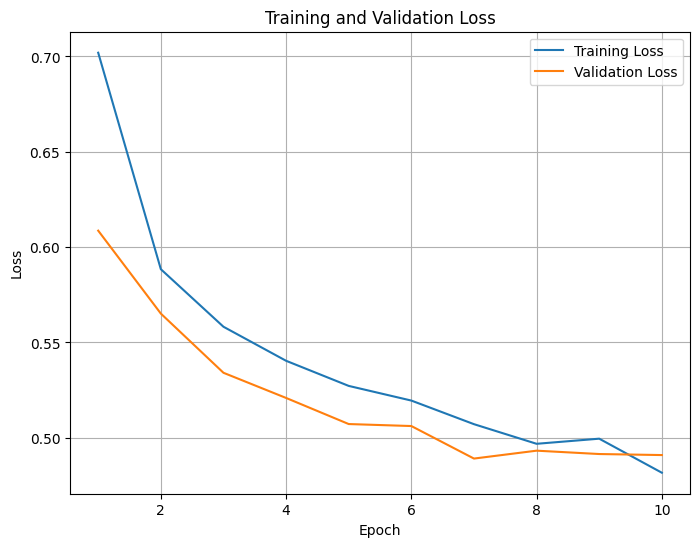

In [149]:
import matplotlib.pyplot as plt
# lossの変化を取得
train_loss = final.history['loss']
val_loss = final.history['val_loss']

# グラフのプロット
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [150]:
df_processed_test =preprocess(df_test)
df_processed_test =pd.DataFrame(scaler.fit_transform(df_processed_test),columns=df_processed_test.columns)
df_processed_test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.873482,0.466044,-0.499470,-0.400248,-0.497063,-0.755929,0.755929,-0.568142,2.843757,-1.350676
1,0.873482,1.415579,0.616992,-0.400248,-0.511926,1.322876,-1.322876,-0.568142,-0.351647,0.740370
2,-0.315819,2.555021,-0.499470,-0.400248,-0.463754,-0.755929,0.755929,-0.568142,2.843757,-1.350676
3,0.873482,-0.103676,-0.499470,-0.400248,-0.482127,-0.755929,0.755929,-0.568142,-0.351647,0.740370
4,0.873482,-0.483490,0.616992,0.619896,-0.417151,1.322876,-1.322876,-0.568142,-0.351647,0.740370


In [151]:
y_pred = model.predict(df_processed_test)

print(y_pred)

df_submit = pd.DataFrame(predictions,columns=['Survived'])#新たな提出用dfを定義
df_submit.Survived = round(df_submit.Survived)
df_submit

14/14 [==============================] - 0s 2ms/step
[[0.07622416]
 [0.29086736]
 [0.06342761]
 [0.09522737]
 [0.33044347]
 [0.14712411]
 [0.6928304 ]
 [0.1581886 ]
 [0.71210504]
 [0.09643028]
 [0.1139621 ]
 [0.16684824]
 [0.9086278 ]
 [0.0563486 ]
 [0.9039416 ]
 [0.85740024]
 [0.0992033 ]
 [0.19249561]
 [0.34154275]
 [0.6667542 ]
 [0.2568645 ]
 [0.21857761]
 [0.91240966]
 [0.44543433]
 [0.90043   ]
 [0.05310068]
 [0.9172453 ]
 [0.18159671]
 [0.18622626]
 [0.14905077]
 [0.07113877]
 [0.14134397]
 [0.24830453]
 [0.31667677]
 [0.37491947]
 [0.21230301]
 [0.5276659 ]
 [0.52887803]
 [0.10130153]
 [0.14231849]
 [0.11096896]
 [0.33357403]
 [0.06679835]
 [0.83680147]
 [0.9035284 ]
 [0.10066402]
 [0.2727529 ]
 [0.10855433]
 [0.91407245]
 [0.36984357]
 [0.34074798]
 [0.21398097]
 [0.68090796]
 [0.8752239 ]
 [0.26017362]
 [0.09009194]
 [0.07663742]
 [0.10055346]
 [0.10617527]
 [0.92017627]
 [0.13069417]
 [0.12069777]
 [0.125955  ]
 [0.71879774]
 [0.50895745]
 [0.8483662 ]
 [0.7259118 ]
 [0.17562

,Survived
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
413,0.0
414,1.0
415,0.0
416,0.0


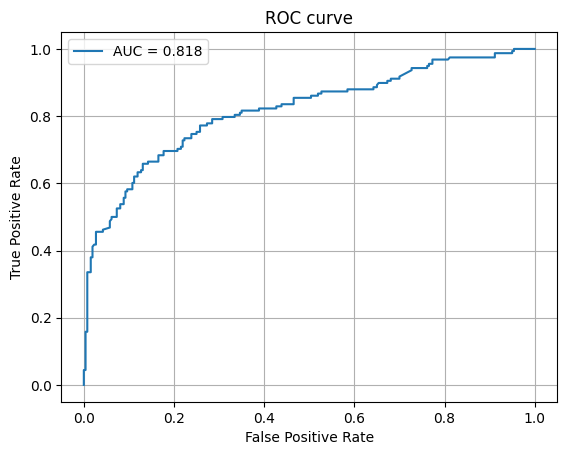

In [152]:
df_answer = pd.read_csv('./kaggle/input/titanic/answer.csv')

Y_test = df_answer['Survived']

Y_test.head()

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
auc_score = roc_auc_score(Y_test, y_pred)
plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)


# accuracy: 0.8208955223880597
# f1_score: 0.7446808510638298
